# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


**Общая информация**

**Срок сдачи:** 25 апреля 18:00 Сдача **очная** на онлайн занятии.


Используйте данный Ipython Notebook при оформлении домашнего задания.

Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0422, Задание 2] Фамилия Имя.



**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$


 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?


***Ваше решение здесь***
$$ w_{new} = w_{old} - \frac{2}{n}X^T(XW-Y)-\frac{2}{C}W $$
$$ X[n, k], W[k, 1], Y[n, 1] $$

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ...$$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.


***Ваше решение здесь***
$$ w_{new} = w_{old} - \frac{1}{n} X^T(\sigma(XW) - Y) - \frac{2}{C}W$$
$$ X[n, k], W[k, 1], Y[n, 1] $$


Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

***Ваше решение здесь***

$$ \nabla_w \left[ -X^TY + (X^TX)w \right] > 0$$
$$  X^TX > 0$$
$ X^TX $ - симметричная матрица. 
Симметричная матрица A размерностью k называется положительно определённой если $$ {\displaystyle \forall z\in \mathbb {R} ^{k}\setminus \{\mathbf {0} \}}{\displaystyle \forall z\in \mathbb {R} ^{k}\setminus \{\mathbf {0} \}:}  {\displaystyle z^{T}Az>0.}$$

$$ z^TX^TXz = (Xz)^T(Xz) = ||Xz||^2 > 0, z\neq0$$

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Ваше решение здесь***

$$\nabla_a E = -\frac{p(y_i = 1 |x_i )}{a(x_i)} + \frac{1 - p(y_i = 1 |x_i )}{1-a(x_i)} = 0$$
$$a(x_i) = p(y_i = 1 |x_i )$$

$$ \nabla_a [-p(y_i = 1 | x_i) \frac{1}{a(x_i)} - (1 - p(y_i = 1 | x_i)) \frac{-1}{1 - a(x_i)}] > 0 $$
$$ \frac{1 - p(y_i = 1 | x_i)}{(a(x_i) - 1)^2} > -\frac{p(y_i = 1 | x_i)}{a(x_i)^2} \quad \blacksquare $$

Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

***Ваше решение здесь***
$$$$
w0 выполняет роль смещения ($ y = w^Tx + w_0$), если мы будем его регуляризировать, то наши предсказания просто будут неправильно смещаться

#  Реализация линейной модели (4 балла)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [118]:
from sklearn import utils
import numpy as np
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    if shuffle:
        X, y = utils.shuffle(X, y)
    for i in np.arange(0, X.shape[0], batch_size):
        yield (X[i:i+batch_size], y[i:i+batch_size])

In [115]:
#%%pycodestyle

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    return 1/(1+np.exp(-x))


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator,
                C=1, 
                C1 = 0.1,
                alpha=0.01, 
                max_epoch=50, 
                batch_size=25, 
                model_type='lin_reg'):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        
        self.C = C
        self.C1 = C1
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        y_batch = y_batch.reshape((-1,1))
        pred = X_batch.dot(self.weights)
        if self.model_type == 'lin_reg':
            loss =  (pred - y_batch).T.dot(pred - y_batch)
        if self.model_type == 'log_reg':
            loss = np.sum(-y_batch*np.log(sigmoid(pred)) - (1 - y_batch)*np.log(1 - sigmoid(pred)))
        loss = loss / X_batch.shape[0] + 1/self.C * self.weights.T.dot(self.weights) + 1 / self.C1 * self.weights
        return loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        y_batch = y_batch.reshape((-1,1))
        pred = X_batch.dot(self.weights)
        if self.model_type == 'lin_reg': 
            cur = X_batch.T.dot(pred - y_batch) * 2 #2((w, x) - y)*x
        if self.model_type == 'log_reg':
            cur = X_batch.T.dot(sigmoid(pred) - y_batch) # -y(1 - si(xw))x + (1-y)si(xw)x = (si(xw) - y)x
        loss_grad = cur/ X_batch.shape[0] + 2 / self.C * self.weights + 1 / self.C1
        return loss_grad
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= self.alpha*new_grad
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        
        alpha = self.alpha
        N = X.shape[1] + 1
        self.weights = np.random.uniform(-1/N, 1/N, N).reshape((-1, 1))
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, batch_size = self.batch_size)
            for batch_num, (X_batch, y_batch) in enumerate(new_epoch_generator):
                X_batch = np.append(X_batch, np.ones((X_batch.shape[0], 1)), axis=1)
                batch_loss = self.calc_loss(X_batch, y_batch)
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
            self.alpha = alpha/(n + 1)**0.5
        self.alpha = alpha
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        X = np.append(X, np.ones((X.shape[0], 1)), axis=1)
        pred = X.dot(self.weights)
        if self.model_type == 'log_reg':
            pred = sigmoid(pred)
        return np.round(pred).astype('int')

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [8]:
#sigmoid(0) = 0.5 -> x*w[0] + y*w[1] + w[2] = 0 -> y = ...
# z = 0.5 = x*w[0] + y*w[1] + w[2] -> y = ...
def plot_decision_boundary(clf):
    x = np.linspace(-5, 8, num=2)
    if clf.model_type == 'log_reg':
        y = (-clf.weights[0] * x - clf.weights[2]) / clf.weights[1] 
    if clf.model_type == 'lin_reg':
        y = (0.5-clf.weights[0] * x - clf.weights[2]) / clf.weights[1] 
    plt.plot(x, y, label=clf.model_type)

Linear regression weights:	[[ 0.12143156 -0.09356377  0.01224355]]

Logistic regression weights:	[[ 1.84455518 -1.86912008 -7.54520692]]


/var/folders/hn/27s2_wp90fn1jnqs60qbkgy40000gn/T/ipykernel_9224/3181138397.py:51: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-y_batch*np.log(sigmoid(pred)) - (1 - y_batch)*np.log(1 - sigmoid(pred)))
/var/folders/hn/27s2_wp90fn1jnqs60qbkgy40000gn/T/ipykernel_9224/3181138397.py:51: RuntimeWarning: invalid value encountered in multiply
  loss = np.sum(-y_batch*np.log(sigmoid(pred)) - (1 - y_batch)*np.log(1 - sigmoid(pred)))


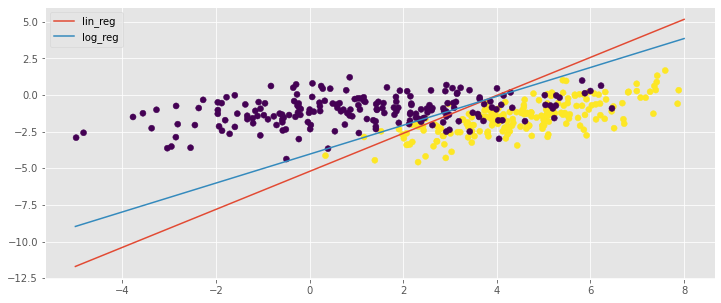

In [9]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

reg = MySGDClassifier(batch_generator=batch_generator, C=1, C1 = 10000,
                             alpha=0.1, max_epoch=100, model_type='lin_reg')
reg.fit(X, y)
print('Linear regression weights:\t{}'.format(np.reshape(reg.weights, (1, -1))), end='\n\n')
plot_decision_boundary(reg)

log = MySGDClassifier(batch_generator=batch_generator, C=10000, C1 = 10000,
                             alpha=10, batch_size=400, model_type='log_reg')
log.fit(X, y)
print('Logistic regression weights:\t{}'.format(np.reshape(log.weights, (1,-1))))
plot_decision_boundary(log)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.legend()

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [10]:
from sklearn.datasets import make_classification

In [11]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

In [ ]:
N = 500
fig, (reg_plot, log_plot) = plt.subplots(1, 2, figsize=(14, 5))
for alpha in np.geomspace(0.01, 0.25, 5):
    reg = MySGDClassifier(batch_generator=batch_generator, C=75000, C1 = 550,
                                alpha=alpha, max_epoch=70, model_type='lin_reg')
    log = MySGDClassifier(batch_generator=batch_generator, C=10000, C1 = 10000,
                                alpha=alpha, batch_size=70, model_type='log_reg')

    reg.fit(X, y)
    x_raxis = np.arange(len(reg.errors_log['loss']) // N)
    y_raxis = list(map(np.mean, np.array_split(reg.errors_log['loss'], len(reg.errors_log['loss']) // N)))
    reg_plot.plot(x_raxis, y_raxis, label = alpha)

    log.fit(X, y)
    x_laxis = np.arange(len(log.errors_log['loss']) // N)
    y_laxis = list(map(np.mean, np.array_split(log.errors_log['loss'], len(log.errors_log['loss']) // N)))
    log_plot.plot(x_laxis, y_laxis, label = alpha)
    
reg_plot.grid(), log_plot.grid()
reg_plot.legend(), log_plot.legend()
reg_plot.set_xlabel('learning process'), log_plot.set_xlabel('learning process')
reg_plot.set_ylim(0.035, 0.05), log_plot.set_ylim(0.05, 0.10)
reg_plot.set_title('linear regression'), log_plot.set_title('logistic regression')

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

/var/folders/hn/27s2_wp90fn1jnqs60qbkgy40000gn/T/ipykernel_1363/3181138397.py:52: RuntimeWarning: overflow encountered in multiply
  loss = loss / X_batch.shape[0] + 1/self.C * self.weights.T.dot(self.weights) + 1 / self.C1 * self.weights
/var/folders/hn/27s2_wp90fn1jnqs60qbkgy40000gn/T/ipykernel_1363/3181138397.py:68: RuntimeWarning: overflow encountered in multiply
  loss_grad = cur/ X_batch.shape[0] + 2 / self.C * self.weights + 1 / self.C1
/var/folders/hn/27s2_wp90fn1jnqs60qbkgy40000gn/T/ipykernel_1363/3181138397.py:76: RuntimeWarning: invalid value encountered in subtract
  self.weights -= self.alpha*new_grad
/var/folders/hn/27s2_wp90fn1jnqs60qbkgy40000gn/T/ipykernel_1363/3181138397.py:51: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-y_batch*np.log(sigmoid(pred)) - (1 - y_batch)*np.log(1 - sigmoid(pred)))
/var/folders/hn/27s2_wp90fn1jnqs60qbkgy40000gn/T/ipykernel_1363/3181138397.py:51: RuntimeWarning: invalid value encountered in multiply
  loss = np.sum(-y_b

(Text(0.5, 1.0, 'linear regression'), Text(0.5, 1.0, 'logistic regression'))

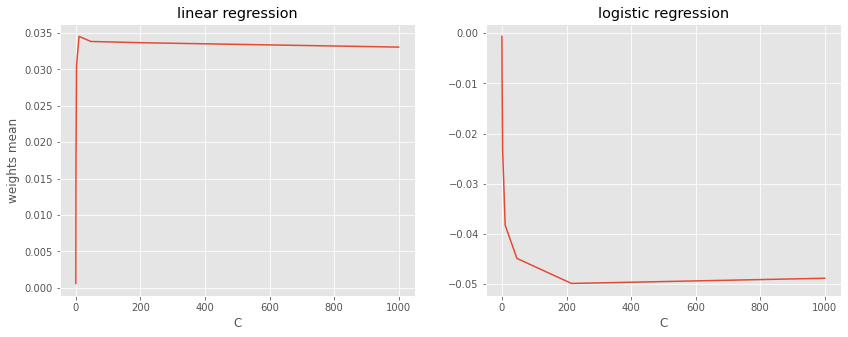

In [ ]:
fig, (reg_plot, log_plot) = plt.subplots(1, 2, figsize=(14, 5))
x_axis = np.logspace(3, -3, 10)
reg_y_axis, log_y_axis = np.zeros(x_axis.shape[0]), np.zeros(x_axis.shape[0])
for i, C in enumerate(x_axis):
    reg = MySGDClassifier(batch_generator=batch_generator, C=C, C1 = 550,
                                alpha=0.015, max_epoch=100, model_type='lin_reg')
    log = MySGDClassifier(batch_generator=batch_generator, C=C, C1 = 10000,
                                alpha=0.01, batch_size=100, model_type='log_reg')

    reg.fit(X, y)
    reg_y_axis[i] = reg.weights.mean()

    log.fit(X, y)
    log_y_axis[i] = log.weights.mean()

reg_plot.plot(x_axis, reg_y_axis), log_plot.plot(x_axis, log_y_axis)
reg_plot.set_xlabel('C'), log_plot.set_xlabel('C')
reg_plot.set_ylabel('weights mean')
reg_plot.set_title('linear regression'), log_plot.set_title('logistic regression')

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

# Боевое применение (4  балла)

**Защита данной части возможна только при преодолении в проекте бейзлайна Handmade baseline.**

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [27]:
import codecs
from bs4 import BeautifulSoup

In [81]:
from pymystem3 import Mystem
import string
from nltk.corpus import stopwords
m = Mystem()

def foo(file_path):
    with codecs.open(file_path, 'r', 'utf-8') as f: 
        soup = BeautifulSoup(f, 'html.parser')
        return soup.text[:soup.text.find('\n')]

def Translator(txt, m):
    for i in string.punctuation:
        txt = txt.replace(i, " ")
    cur = txt.translate(str.maketrans(' ', ' ',  "•"
                                                   + '\n' + '\t')).lower()
    cur = cur.translate(str.maketrans('', '', string.digits))
    cur = m.lemmatize(cur)
    cur = [word.strip() for word in cur if not word.strip() in stopwords.words('russian')
                                               and not word.strip() in stopwords.words('english')
                                               and len(word.strip()) > 2
                                               and word.strip() != "none"
                                               and word.strip()[:4] != "http"]
    return " ".join(cur)

doc_to_title = {}
with open('data/docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = Translator(title, m)
        # doc_to_title[doc_id] = title
        
for i in doc_to_title:
    doc_to_title[i] += " " + str(len(doc_to_title[i].split()))
    # path = f'content/{i}.dat'
    # domen = foo(path)
    # domen = domen[domen.find('.')+1:]
    # print(domen)
    # if len(domen) > 20: domen = ""
    # doc_to_title[i] += " " + domen
print(len(doc_to_title))

28026


In [88]:
for ind in tqdm(doc_to_title):
    path = f'content/{ind}.dat'
    domen = foo(path)
    domen = domen[:domen.find('.')]
    if len(domen) > 30: domen = ''
    doc_to_title[ind] = doc_to_title[ind] + " " + domen

100%|██████████| 28026/28026 [40:44<00:00, 11.46it/s]  


In [87]:
def foo(file_path):
    with codecs.open(file_path, 'r', 'utf-8') as f: 
        soup = BeautifulSoup(f, 'html.parser')
        return soup.text[:soup.text.find('\n')]

path = f'content/1002.dat'
domen = foo(path)
domen = domen[:domen.find('.')]
domen

'goodquestion'

In [138]:
doc_to_title[15731]

'ваз замена подшипник ступица нива 5 automn'

In [133]:
import pandas as pd
train_data = pd.read_csv('data/train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append([doc_id, title, target])

In [134]:
"""->profit<-"""
import operator
for group in traingroups_titledata:
    group_dict = {}
    for doc, title, target in traingroups_titledata[group]:
        for i in title.split():
            group_dict[i] = group_dict.get(i, 0) + 1
    golden_title = dict(sorted(group_dict.items(), key=operator.itemgetter(1))[-10:])
    for ind, data in enumerate(traingroups_titledata[group]):
        data_c = data[1][:-2].split()
        for k in set(data_c):
            if k in golden_title:
                # if data_c[data_c.index(k) - 1] in golden_title:
                #     traingroups_titledata[group][ind][1] += " " + str(k) + " " + str(data_c[data_c.index(k) - 1])
                # else:
                traingroups_titledata[group][ind][1] += " " + str(k)

In [135]:
traingroups_titledata[100][3]

[8495, 'взять поход отдыхать россия 4 travellling взять поход 4', 1]

In [136]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import pdist, squareform

vectorizer = TfidfVectorizer()


X, y, groups = [], [], []
for group, docs in traingroups_titledata.items():
    doc_id, title, target = zip(*docs)
    distances = pdist(vectorizer.fit_transform(title).toarray(), 'cosine')
    distances[np.where(np.isnan(distances))[0]] = 1.
    features = np.sort(squareform(distances))[:, 1:26]
    X.extend(features)
    y.extend(target)
    groups.extend([group] * len(target))
X, y, groups = np.array(X), np.array(y), np.array(groups)

In [17]:
X.shape

(11690, 25)

Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [15]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, GroupKFold

In [119]:
train_indices, test_indices = next(GroupKFold(n_splits=15).split(X, y, groups))
scaler = StandardScaler()
scaler.fit(X)

# my_clf = MySGDClassifier(batch_generator=batch_generator, C=100000, alpha=0.0035,
#                          max_epoch=20, batch_size=20, model_type='log_reg')
#my_clf = GradientBoostingClassifier(loss='exponential', learning_rate=0.15)
#my_clf = CatBoostClassifier(loss_function='Logloss', verbose=False, iterations=1000, boosting_type="Ordered")
X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test   = X[test_indices], y[test_indices]
X_train, X_test  = scaler.transform(X_train), scaler.transform(X_test)
#%time my_clf.fit(X_train, y_train, plot=True)
f1_score(y_test, my_clf.predict(X_test))

0.8274582560296846

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [137]:
scaler = StandardScaler()
scaler.fit(X)
X_ = scaler.transform(X)
cross_validation = GroupKFold(n_splits=10).split(X_, y, groups)
my_clf_reg = MySGDClassifier(batch_generator=batch_generator)
params = {
    'C': [75000],
    'C1': [550],
    'alpha': [0.015],
    'max_epoch': [500]
}
grid_search = GridSearchCV(my_clf_reg, param_grid=params,
                           cv=cross_validation, n_jobs=-1)
%time grid_search.fit(X_, y)

grid_search.best_params_

CPU times: user 9.33 s, sys: 224 ms, total: 9.56 s
Wall time: 24.3 s


{'C': 75000, 'C1': 550, 'alpha': 0.015, 'max_epoch': 500}

In [101]:
i = 0

In [148]:
from tqdm import tqdm


my_clf = CatBoostClassifier(loss_function='Logloss',
                            depth=10,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            #eta=0.1,
                            leaf_estimation_method = 'Gradient',
                            custom_loss=['F1', 'Precision', 'Recall'])
cross_validation = GroupKFold(n_splits=25).split(X, y, groups)
for train_index, test_index in tqdm(cross_validation):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    train_scaler, test_scaler = StandardScaler(), StandardScaler()
    train_scaler.fit(X_train), test_scaler.fit(X_test)
    X_train, X_test = train_scaler.transform(X_train), test_scaler.transform(X_test)
    my_clf.fit(X_train, y_train, plot=True)
    print(f1_score(my_clf.predict(X_test), y_test))
# splitter = GroupShuffleSplit(test_size=.90, n_splits=2, random_state=0)
# split = splitter.split(X, y, groups=groups)
# train_inds, test_inds = next(split)
# X_train, y_train = X[train_inds], y[train_inds]
# X_test, y_test = X[test_inds], y[test_inds]
# # train_scaler, test_scaler = StandardScaler(), StandardScaler()
# # train_scaler.fit(X_train), test_scaler.fit(X_test)
# # X_train, X_test = train_scaler.transform(X_train), test_scaler.transform(X_test)
# my_clf.fit(X_train, y_train, plot=True)
# print(f1_score(my_clf.predict(X_test), y_test))
# my_clf.save_model(f'/Users/vadimvorobev/~/code/VK/ml/Project/data/stacking/0{i}')
i+=1


0it [00:00, ?it/s]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

1it [01:42, 102.13s/it]

0.3592233009708738


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2it [03:26, 103.44s/it]

0.5306122448979591


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

3it [05:14, 105.48s/it]

0.4736842105263158


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

4it [06:48, 101.03s/it]

0.6060606060606061


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

5it [08:22, 98.41s/it] 

0.7499999999999999


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

6it [09:50, 95.06s/it]

0.5542168674698795


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

7it [11:18, 92.59s/it]

0.393063583815029


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

8it [12:46, 91.09s/it]

0.31213872832369943


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

9it [14:13, 89.78s/it]

0.6984126984126985


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

10it [15:40, 89.00s/it]

0.5803571428571428


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

11it [17:07, 88.31s/it]

0.7025089605734767


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

12it [18:34, 87.89s/it]

0.7860696517412936


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

13it [20:00, 87.57s/it]

0.6322580645161291


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

14it [21:28, 87.51s/it]

0.755952380952381


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

15it [22:55, 87.39s/it]

0.6145552560646902


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

16it [24:22, 87.30s/it]

0.3548387096774193


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

17it [25:50, 87.40s/it]

0.6072607260726073


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

18it [27:17, 87.35s/it]

0.589090909090909


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

19it [28:46, 87.83s/it]

0.483695652173913


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

20it [30:13, 87.59s/it]

0.5038167938931297


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

21it [31:40, 87.56s/it]

0.5726872246696034


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

22it [33:08, 87.52s/it]

0.49056603773584895


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

23it [34:35, 87.39s/it]

0.6319444444444444


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

24it [36:02, 87.40s/it]

0.6470588235294118


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

25it [37:29, 90.00s/it]

0.6627218934911243


In [150]:
s.fit(X)
f1_score(my_clf.predict(s.transform(X)), y)

0.846991946944576

In [ ]:
my_clf.save_model("data/models/q1")

In [264]:
from catboost import  sum_models
from sklearn.linear_model import LinearRegression

In [ ]:
np.argmax()

In [220]:
models = []
for i in range(5):
    m = CatBoostClassifier()
    m.load_model(f"data/models/0{i}")
    models.append(m)
models_weights = np.arange(1,6) / 5
models_weights = models_weights / np.sum(models_weights)

In [348]:
models_pred = pd.DataFrame()
s = StandardScaler()
s.fit(X)
for i, m in enumerate(models):
    models_pred[f"{i}"] = m.predict(s.transform(X))

In [ ]:
# scaler.fit(X)
# X_ = scaler.transform(X)
# cross_validation = GroupKFold(n_splits=5).split(X, y, groups)
# my_clf = CatBoostClassifier()
# grid = {'learning_rate' : [0.35],
#         'depth' : [10],
#         'l2_leaf_reg' : [1]}
# grid_search_result = my_clf.grid_search(grid, X_, y, cv=cross_validation, plot=True, shuffle=False)

Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

In [151]:
test_data = pd.read_csv('data/test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append([doc_id, title])

In [152]:
import operator
for group in testgroups_titledata:
    group_dict = {}
    for doc, title in testgroups_titledata[group]:
        for i in title.split():
            group_dict[i] = group_dict.get(i, 0) + 1
    golden_title = dict(sorted(group_dict.items(), key=operator.itemgetter(1))[-10:])
    for ind, data in enumerate(testgroups_titledata[group]):
        data_c = data[1][:-2].split()
        for k in set(data_c):
            if k in golden_title:
                if data_c[data_c.index(k) - 1] in golden_title:
                #     testgroups_titledata[group][ind][1] += " " + str(k) + " " + str(data_c[data_c.index(k) - 1])
                    testgroups_titledata[group][ind][1] += " " + str(k)
testgroups_titledata[130][:5]

[[6710, 'прописывать админка друг youtube 4 youtube админка'],
 [4030,
  'скачать sgl доработка слива мода mysql role play готовый сервер samp sampe samp gta 14 v-sampe'],
 [5561,
  'прописывать админка counter strike каталог статья игровой сообщество dream counter strike портал 12 dream-x админка'],
 [4055, 'прописывать простой админка 3  прописывать'],
 [4247, 'подбор админ сервер код архив форум ozone 7 o3one']]

In [153]:
X_test, groups_test = [], []
for group, docs in testgroups_titledata.items():
    doc_id, title = zip(*docs)
    distances = pdist(vectorizer.fit_transform(title).toarray(), 'cosine')
    distances[np.where(np.isnan(distances))[0]] = 1.
    features = np.sort(squareform(distances))[:, 1:26]
    X_test.extend(features)
    groups_test.extend([group] * len(doc_id))
X_test, groups_test = np.array(X_test), np.array(groups_test)

In [48]:
# scaler = StandardScaler()
# scaler.fit(X_test)

# models_pred = pd.DataFrame()
# s = StandardScaler()
# s.fit(X_test)
# for i, m in enumerate(models):
#     models_pred[f"{i}"] = m.predict(s.transform(X_test))
# a = reg.predict(models_pred)
# a[a >= 0.5] = 1
# a[a < 0.5] = 0
# plt.hist(a)

In [13]:
my_clf = CatBoostClassifier()
my_clf.load_model('data/models/q1')

In [154]:
from csv import DictWriter



#a = models[-3].predict(scaler.transform(X_test)).flatten()

s = StandardScaler()
s.fit(X_test)
# a = grid_search.predict(scaler.transform(X_test)).flatten()
a = my_clf.predict(s.transform(X_test)).flatten()
# a = my_clf.predict(s.transform(X_test)).flatten()
    
with open('data/05.csv', 'w') as f:
    fieldnames = ['pair_id', 'target']
    writer = DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    i = 11691
    for elem in a:
        writer.writerow({'pair_id': str(i), 'target': str(int(elem))})
        i += 1

In [155]:
np.sum(a == 1)

3806

In [18]:
X_test.shape

(16627, 25)

(array([11959.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  4668.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

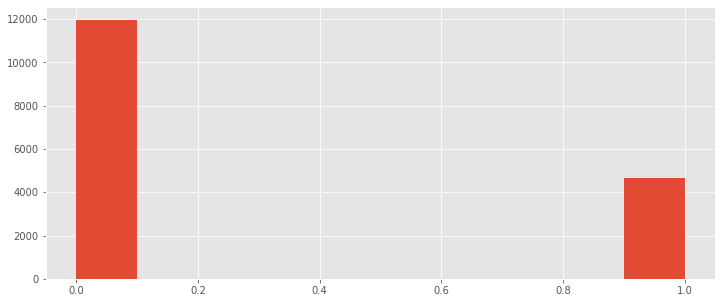

In [125]:
def f(x):
    if x == 2:
        return 1
    else:
        return x
df = pd.read_csv('data/05.csv')
df["target"] = df["target"].apply(lambda x : f(x))
df.to_csv("data/05.csv", index=False)
plt.hist(df.target)

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук показать Ваш ник на kaggle, под которым Вы залили решение, которое побило Handmade baseline. **

In [110]:
from model import word_generator
word_generator(["инстаграм"], num=20)

{'блог',
 'видео',
 'журнал',
 'звезда',
 'зритель',
 'интернет',
 'комментарий',
 'пользователь',
 'портал',
 'публикация',
 'реклама',
 'рекламный',
 'ролик',
 'сайт',
 'сеть',
 'социальный',
 'страница',
 'форум',
 'фотография',
 'шоу'}

<h2>Kaggle: esjxjc(Puseferg)</h2>

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

Для меня важно было скорее понять где у меня пробелы в знаниях, это уже дело не простое. Восполнять их лучше самостоятельно, так как сам себя человек знает лучше, чем кто-либо другой.

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***